# 1) Notes: 

## THERE IS A "BUMP" IN MANTLE TEMPERATURE AT LATE TIMES WHEN USING THE EQUATION FOR Q(TAU_HEAT) FROM THE PAPER (I.E., tau_decay/(rho_m * c_p * T_ref/Q_0) INSTEAD OF THE SMOOTH EVOLUTION OF MANTLE TEMPERATURE IN TAD'S CODE USING (tau_decay/(rho_m * c_p * T_ref/F_0). COULD THIS BUMP BE REAL??? WHY DOES CHANGING THE NON-DIMENSIONAL TIMESCALE CAUSE THIS?
## --> INTERESTINGLY, THIS ONLY REMOVES THE BUMP WHEN THE TIMESCALE IS CHANGED IN THE EXPONENTIAL, WHILE THE REST OF THE EQUATION IS THE SAME AS IN THE PAPER. (XXXX IS THIS ACTUALLY HAPPENING? TEST THESE VALUES AGAIN LATER XXXX)

## ACCORDING TO TAD, REGASSING CHECK IS "WONKY" -- FIGURE OUT A BETTER WAY TO DO THIS IN SIMPLE ANALYTIC MODEL (OR USE A MORE COMPLICATED MODEL, I.E. LAURA'S)

## TOTAL WATER MASS FRACTION VARYING WITH TIME FOR LOSS -- CHECK EACH FUNCTION THAT DEPENDS ON THE TOTAL VALUE, AND NOT JUST THE INITIAL VALUE!

# 2) XXXX Things to vary, once code runs with loss XXXX
## Make robust to dessication -- should still be able to cycle if one reservoir is empty (currently the integrations don't work for SS and hybrid models in this limit) --> i.e., catches for rates going to 0 (or infinity), similar to what Tad has done
## - total initial water [a) surface, b) interior]
## - water loss [c) rate, d) timescale]
## -- *Sensitivity Analysis*

# 3) XXXX Code Improvements XXXX
## - Laura's code
## - Better atmospheric loss (diffusion-limited escape; as opposed to energy-limited); accounting for planetary climate, atmospheric composition; wind-driven --> magnetic field --> mantle convection --> dynamo in outer core; hydrogen-generation --> photolysis of water and methane (our assumptions for now), OR serpentinization if iron-rich rock
## - Convection speed and regassing efficiency

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Constants from Tad's code.
M_E = 5.972e24
R_E = 6.371e6
x_h = 0.05
rho_c = 3.e3
chi = 0.23
d_hE = 3e3
rho_m = 3.3e3
d_melt = 60.e3
f_degasE = 0.9
G = 6.67e-11
P_E = 4.e7
f_M = 0.68
f_b = 0.9
omega_0 = 2.3e-4
f_btwid = 1.3
year = 3.154e+7 #seconds per year
num_oceans = 1. #multiple of oceans compared to Earth, could use 1. or 10.
omg_Etwid = num_oceans*6.2e-4/2.3e-4 # from CA2014: omega/omega_0

In [3]:
# More constants from Tad's code.
E_a = 335.e3 #activation energy
R_g = 8.314 #gas constant
alpha = 2.e-5 #coefficent of thermal expansion
Ra_c = 1100. #critical Rayleigh number
kappa = 1.e-6 #mantle thermal diffusivity
T_ref = 1600. #reference temperature
#eta_0 = 1.e21
#eta_0 = 1.e16
#eta_0 = 9.03e24 # XXX CHANGE THIS LATER IF MASS OF PLANET CHANGES XXX
k = 4.2 #mantle thermal conductivity
beta = 0.3 #scaling exponent
c_p = 1200. #mantle heat capacity
Q_0 = 5.e-8
year = 3.154e7 #seconds per year

In [4]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x_twid): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    omega_0 = omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    
    x = x_twid*omega_0*f_btwid/f_M
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_wtwid(x_twid):
    
    return np.exp(lnf_w(x_twid)) / (np.exp(lnf_w(1.)))

In [5]:
## MANTLE VISCOSITY

r_fug = 1.
eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
eta_0 = 1.e21/eta_scale

# Need a function to calculate the viscosity.
def eta(x_twid, T_twid): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    E_a = 335.0e3
    R_g = 8.314
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600 #[K]
    
    f_w = np.exp(lnf_w(x_twid)) #lnf_w needs non-dimensionalized x
    
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    return eta_0 * (f_w**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))

In [6]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def gtwid(M): #dimensionless gravity, normalized to Earth (FOR NOW)
    return g(M)/9.8

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M):
    T_ref = 1600.
    beta = 0.3
    alpha = 2.0e-5 #coefficent of thermal expansion
    rho_m = 3.3e3
    Ra_c = 1100. #critical Rayleigh number
    kappa = 1.0e-6 #mantle thermal diffusivity
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(1.))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(T_twid, x_twid, M):
    kappa = 1.0e-6
    beta = 0.3
    alpha = 2.0e-5
    rho_m = 3.3e3
    T_s = 280.
    Ra_c = 1100.
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600 #[K]
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*(T-T_s)/(eta(x_twid,T_twid)*Ra_c))**(2.*beta))

def tau(M): #useful for converting between different non-dimensional timescales
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

# CA Model, using scipy.integrate --> GOOD! LOSS INCLUDED!
## scipy.optimize, with the integrator option 'vode', seems to be the best for this.

In [63]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

def f_delta_temp_CA(t_twid, temp_twid, x_twid, M):
    Q_0 = 5.0e-8
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    #tau_heat = Q_0/(rho_m*c_p*T_ref)
    
    #tau_decay = 2.0e9*3.154e7
    tau_decay_twid = 2.0e9*3.154e7/(rho_m*c_p*T_ref/F_0(M))
    #tau_decay_twid = 2.0e9*3.154e7/(rho_m*c_p*T_ref/Q_0) #TEST Q_0 against F_0 in taudecay
    F_0twid = F_0(M)/Q_0
    beta = 0.3
    T_stwid = 280./1600.
    
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a)
    #(tau_heat/tau(M))* on the first term?
    return ((1./F_0twid)*np.exp(-t_twid/tau_decay_twid)) - \
        ((f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_CA(t_twid, x_twid, s_twid, M):
    sigma = 1.
    mu = 1.
    
    x_h = 0.05
    rho_c = 3.0e3
    chi = 0.23
    d_hE = 3.0e3
    f_M = 0.68
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_degasE = 0.9
    omega_0 = 2.3e-4
    f_btwid = 1.3
    Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        return ((gtwid(M)**2.)*s_twid)**sigma - (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        return ((gtwid(M)**2.)*s_twid)**sigma - 0.
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        return 0. - (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    
    else: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_CA(t_twid, x_twid, s_twid, M):
    sigma = 1.
    mu = 1.
    
    x_h = 0.05
    rho_c = 3.0e3
    chi = 0.23
    d_hE = 3.0e3
    f_M = 0.68
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_degasE = 0.9
    omega_0 = 2.3e-4
    f_btwid = 1.3
    Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
    
    # Terms for loss # XXXX ALL CONDITIONS HERE CAN BE CHANGED LATER XXXX
    omg_Etwid = 6.2e-4/2.3e-4
    f_btwid = 1.3
    omegatwid = omg_Etwid/(f_btwid)
    year = 3.154e7
    t_loss = 1.0e8 #e-folding timescale of 100 Myr
    loss_factor = 10.*(Xtwid**-1.)*omegatwid/2.*((gtwid(M)**2.)*omegatwid/2.)**(-mu)
    # loss factor is 10 times the initial degassing rate (FOR NOW)
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        #return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu) - ((gtwid(M)**2.)*s_twid)**sigma # no loss
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu) - ((gtwid(M)**2.)*s_twid)**sigma \
            - loss_factor*np.exp(-(t_twid/tau(M)/year)/t_loss)
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        return 0. - ((gtwid(M)**2.)*s_twid)**sigma - loss_factor*np.exp(-(t_twid/tau(M)/year)/t_loss)
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu) - 0.
    
    else: #no degassing, no regassing
        return 0. - 0.
    

# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_CA(t_twid, z, M):
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    #Q_0 = 5.0e-8
    #F_0twid = F_0(M)/Q_0
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    
    return [(F_0(M)/(rho_m*c_p*T_ref*tau(M)))*f_delta_temp_CA(t_twid, temp_twid, x_twid, M), f_delta_x_CA(t_twid, x_twid, s_twid, M), f_delta_s_CA(t_twid, x_twid, s_twid, M)]

In [64]:
#year = 3.154e7
#t_loss = 1.0e8*year #e-folding timescale of 100 Myr
#Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
#mu = 1.
#loss_factor = 10.*(Xtwid**-1.)*omegatwid/2.*((gtwid(M)**2.)*omegatwid/2.)**(-mu)

#print(year, t_loss, loss_factor)
#print(np.exp(-1e-5*tau(M_E)*year)/t_loss)
#print(loss_factor)
#print(loss_factor*np.exp(-(1e-5/tau(M_E)/year)/t_loss))

In [65]:
print(1e-5*2.87e9)
print(1e-5/tau(M_E)/year)

28700.000000000004
28732.40008111381


In [66]:
### Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_CA(t_twid, x_twid, s_twid, M):
    sigma = 1.
    
    if s_twid > 0.: #normal regassing
        return ((gtwid(M)**2.)*s_twid)**sigma
    else: #if s_twid <= 0; no regassing
        return 0.
    
def f_degas_CA(t_twid, x_twid, s_twid, M):
    mu = 1.
    
    x_h = 0.05
    rho_c = 3.0e3
    chi = 0.23
    d_hE = 3.0e3
    f_M = 0.68
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_degasE = 0.9
    omega_0 = 2.3e-4
    f_btwid = 1.3
    Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
    
    if x_twid > 0.: #normal degassing
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    else: #if x_twid <= 0.; no degassing
        return 0.
    
def f_loss_CA(t_twid, x_twid, s_twid, M):
    sigma = 1.
    mu = 1.
    
    x_h = 0.05
    rho_c = 3.0e3
    chi = 0.23
    d_hE = 3.0e3
    f_M = 0.68
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_degasE = 0.9
    omega_0 = 2.3e-4
    f_btwid = 1.3
    Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
    
    # Terms for loss # XXXX ALL CONDITIONS HERE CAN BE CHANGED LATER XXXX
    omg_Etwid = 6.2e-4/2.3e-4
    f_btwid = 1.3
    omegatwid = omg_Etwid/(f_btwid)
    year = 3.154e7
    t_loss = 1.0e8 #e-folding timescale of 100 Myr
    loss_factor = 10.*(Xtwid**-1.)*omegatwid/2.*((gtwid(M)**2.)*omegatwid/2.)**(-mu)
    
    if s_twid > 0.: #normal loss
        return loss_factor*np.exp(-(t_twid/tau(M)/year)/t_loss)
    else: #if s_twid <= 0; no loss
        return 0.

In [202]:
print(f_degas_CA(0.,omegatwid/2.,omegatwid/2.,M_E))
print(f_regas_CA(0.,omegatwid/2.,omegatwid/2.,M_E))
print(f_loss_CA(0.,omegatwid/2.,omegatwid/2.,M_E))

0.7549547662687315
1.039678827134008
7.549547662687315


In [67]:
# Set initial conditions.
omegatwid = omg_Etwid/(f_btwid)
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_CA).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 100.
dt = 1.e-5
t_array_CA = np.zeros(int(t1/dt)+1)
T_array_CA = np.zeros(int(t1/dt)+1)
x_array_CA = np.zeros(int(t1/dt)+1)
s_array_CA = np.zeros(int(t1/dt)+1)
regas_array_CA = np.zeros(int(t1/dt)+1)
degas_array_CA = np.zeros(int(t1/dt)+1)
loss_array_CA = np.zeros(int(t1/dt)+1)
#d_hydr_CA = np.zeros(int(t1/dt))
#eta_array_CA = np.zeros(int(t1/dt))

# Initial values in the arrays.
t_array_CA[0] = t0
T_array_CA[0] = z0[0]
x_array_CA[0] = z0[1]
s_array_CA[0] = z0[2]
regas_array_CA[0] = f_regas_CA(t0, z0[1], z0[2], M)
degas_array_CA[0] = f_degas_CA(t0, z0[1], z0[2], M)
loss_array_CA[0] = f_loss_CA(t0, z0[1], z0[2], M)

# Integrate the above function.
idx = 1
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_CA[idx] = r.t
    T_array_CA[idx] = r.y[0]
    x_array_CA[idx] = r.y[1]
    s_array_CA[idx] = r.y[2]
    regas_array_CA[idx] = f_regas_CA(r.t, r.y[1], r.y[2], M)
    degas_array_CA[idx] = f_degas_CA(r.t, r.y[1], r.y[2], M)
    loss_array_CA[idx] = f_loss_CA(r.t, r.y[1], r.y[2], M)
    idx = idx + 1

In [163]:
print(loss_factor)

7.549547662687315


<Figure size 1224x540 with 0 Axes>

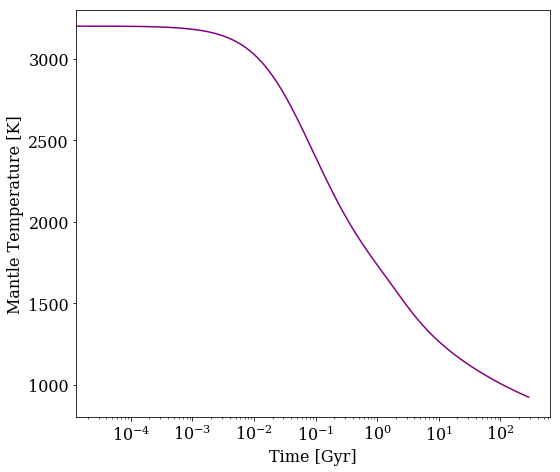

In [69]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_CA*2.87, T_array_CA*1600., color='purple')
plt.ylim([800,3300])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
#plt.savefig('Recoded_CA_Model_MantleTemp_noloss.pdf', bbox_inches='tight')
plt.savefig('Recoded_CA_Model_MantleTemp_exploss.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


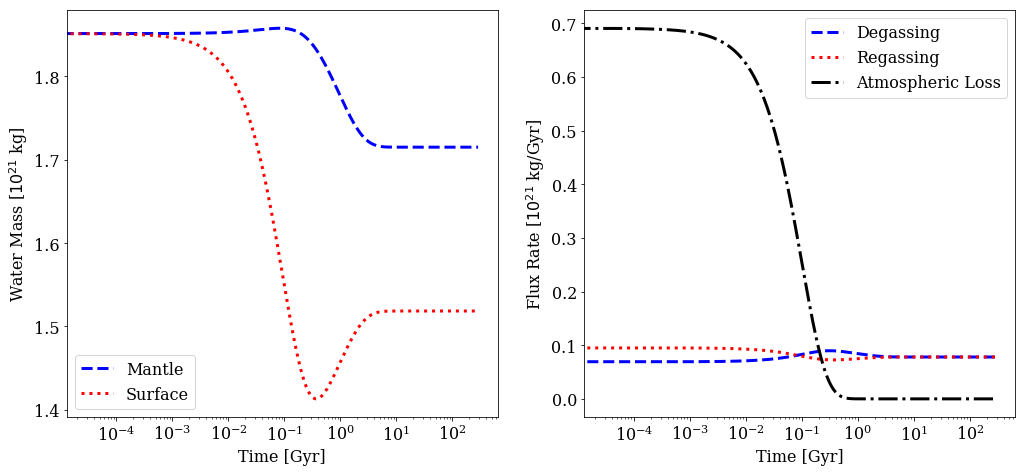

In [70]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] #IS THIS CORRECT? CHECK MASS FRACTIONS

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_CA*2.87, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_CA*2.87, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
#plt.semilogx([0., 287], [1.32*kg_conv/1000./1.0e18, 1.32*kg_conv/1000./1.0e18], color='k', linestyle='--', label='Earth Mantle Water')
#plt.semilogx([0., 287], [1.39, 1.39], color='k', linestyle=':', label='Earth Surface Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_CA*2.87, (degas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA*2.87, (regas_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_CA_model_cycling_noloss.pdf', bbox_inches='tight')
plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')

# SS Model using scipy.integrate

In [169]:
# Define functions to be used within this model (and hybrid), based on mass.
# Need a function to calculate the non-dimensional timescale of SS model.
chi_d = 0.02
chi_r = 0.03
theta = 1.5 #melt fraction exponent
T_liq_dry = 1225.+273.15
T_sol_dry = 975.+273.15
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref

Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))

def D(M):
    x_h = 0.05
    rho_c = 3.0e3
    chi_r = 0.03
    beta = 0.3
    T_serp = 973.
    T_s = 280.
    T_ref = 1600.
    kappa = 1.0e-6
    Ra_c = 1100.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    alpha = 2.0e-5
    rho_m = 3.3e3
    f_w = np.exp(lnf_w(1.))
    
    return x_h*rho_c*chi_r*(h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*\
        (kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*f_w))**beta

def Sigma(M):
    omega_0 = 2.3e-4
    f_btwid = 1.3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    alpha = 2.0e-5
    rho_m = 3.3e3
    T_ref = 1600.
    
    f_w = np.exp(lnf_w(1.))
    
    return M*omega_0*f_btwid*((h(M)**(1.-6.*beta))*(kappa**(2.*beta-1.))/\
        (10.76*L_MOR(M)))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*f_w))**(2.*beta)

def tau_SS(M):
    return D(M)/Sigma(M)

def Pitwid(M):
    rho_m = 3.3e3
    d_melt = 60.0e3
    chi_d = 0.02
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    T_ref = 1600.
    T_liqtwid = (1225.+273.15)/T_ref
    T_soltwid = (975.+273.15)/T_ref
    theta = 1.5
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    return Pi/D(M)

def D_2(M):
    beta = 0.3
    T_serp = 973.
    T_s = 280.
    T_ref = 1600.
    kappa = 1.0e-6
    Ra_c = 1100.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.e21/eta_scale
    alpha = 2.0e-5
    rho_m = 3.3e3
    return (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta

def D_2_max(temp_twid, x_twid, s_twid, M):
    omega_0 = 2.3e-4
    f_btwid = 1.3
    x_h = 0.05
    rho_m = 3.3e3
    beta = 0.3
    T_ref = 1600.
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a)
    T_stwid = 280./1600.
    
    return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
        np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(1.+beta))

def f_Pitwid_max(temp_twid, x_twid, s_twid, M):
    chi_d = 0.02
    chi_r = 0.03
    theta = 1.5 #melt fraction exponent
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_ref = 1600.
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_btwid = 1.3
    f_M = 0.68
    x_h = 0.05
    rho_c = 3.0e3
    omega_0 = 2.3e-4

    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    
    return Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)

tau_heat = Q_0/(rho_m*c_p*T_ref) #NOTE: TAD USES F_0 IN PLACE OF Q_0 IN THIS TIMESCALE

In [219]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

# XXXX ARE THE MANTLE TEMPERATURE FUNCTIONS THE SAME NOW? IF SO, ONLY DEFINE ONE XXXX
def f_delta_temp_SS(t_twid, temp_twid, x_twid, M):
    Q_0 = 5.0e-8
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    #tau_heat = Q_0/(rho_m*c_p*T_ref)
    
    #tau_decay = 2.0e9*3.154e7
    tau_decay_twid = 2.0e9*3.154e7/(rho_m*c_p*T_ref/F_0(M))
    F_0twid = F_0(M)/Q_0
    beta = 0.3
    T_stwid = 280./1600.
    
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a)
    #(tau_heat/tau(M))* on the first term?
    return ((1./F_0twid)*np.exp(-t_twid/tau_decay_twid)) - \
        ((f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M):
    chi_d = 0.02
    chi_r = 0.03
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    #D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Pitwid_max = Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    #Pitwid_max = f_Pitwid_max(temp_twid, x_twid, s_twid, M)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid

    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif s_twid < 0:
                return 0. - (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif s_twid < 0:
                return 0. - 0.
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid < 0:
            return 0. - 0.
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return 0. - (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            return 0. - 0.
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0.
                    
def f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M): # NEED TO ADD LOSS TO THIS 
    chi_d = 0.02
    chi_r = 0.03
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    #D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Pitwid_max = Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # Terms for loss # XXXX ALL CONDITIONS HERE CAN BE CHANGED LATER XXXX
    omg_Etwid = 6.2e-4/2.3e-4
    f_btwid = 1.3
    omegatwid = omg_Etwid/(f_btwid)
    year = 3.154e7
    t_loss = 1.0e8 #e-folding timescale of 100 Myr
    #loss_factor = 10.*(Pi/D(M))*(f_wtwid(omegatwid/2.)**(2.*beta))*((2.-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
    #            ((1./2.)-1.))*(omegatwid/2.)*((2.-T_soltwid+(lambdatwid*((omegatwid/2.)**gamma)))**theta)
    
    loss_factor = 10.*7.549547662687315
    #loss factor is 10 times the initial CA degassing rate (FOR NOW)
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                    (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
            elif s_twid < 0:
                return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. \
                    - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                return 0. - (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                return 0. - (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                    - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
            elif s_twid < 0:
                return 0. - 0. - 0.
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return 0. - (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return 0. - (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
        elif s_twid < 0:
            return 0. - 0. - 0.
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            return 0. - 0. - 0.
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_SS(t_twid, z, M):
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    #Q_0 = 5.0e-8
    #F_0twid = F_0(M)/Q_0
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    d_melt = 60.0e3
    chi_d = 0.02
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    theta = 1.5
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))

    # Dividing by tau(M) helps put these on the same timescale.
    return [(F_0(M)/(rho_m*c_p*T_ref*tau(M)))*f_delta_temp_SS(t_twid, temp_twid, x_twid, M),\
            (Pi/(Sigma(M)*tau(M)))*f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M),\
            (Pi/(Sigma(M)*tau(M)))*f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M)]


In [220]:
T_stwid = 280./1600.
E_a = 335.0e3
R_g = 8.314
T_ref = 1600.
beta = 0.3
theta = 1.5
gamma = 0.75
T_mtwid = T_ref*R_g/(E_a)
K_cnst = 43.
Ktwid = K_cnst/T_ref
omega_0 = 2.3e-4
f_btwid = 1.3
f_M = 0.68
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)


print(f_regas_SS(0.,2.,omegatwid/2.,omegatwid/2.,M_E))
print(f_degas_SS(0.,2.,omegatwid/2.,omegatwid/2.,M_E))
print(f_loss_SS(0.,2.,omegatwid/2.,omegatwid/2.,M_E))

289.35195673462124
4014.2710568589505
150.9909532537463


In [221]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_SS(t_twid, temp_twid, x_twid, s_twid, M): # NEED TO ADD LOSS.
    chi_d = 0.02
    chi_r = 0.03
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    #D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Pitwid_max = Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.: #water on surface
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0:
            return 0.
                
    elif s_twid <= 0.: #no water on surface; no regassing
        return 0.
    
def f_degas_SS(t_twid, temp_twid, x_twid, s_twid, M):
    chi_d = 0.02
    chi_r = 0.03
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    
    Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
    #D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Pitwid_max = Pi/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0.: #water in mantle
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            return 0.
                                                                                        
    elif x_twid <= 0.: #no water in mantle; no degassing
        return 0.
    
def f_loss_SS(t_twid, temp_twid, x_twid, s_twid, M):
    T_ref = 1600.
    T_stwid = 280./T_ref
    beta = 0.3
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    gamma = 0.75
    theta = 1.5
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    
    # Terms for loss # XXXX ALL CONDITIONS HERE CAN BE CHANGED LATER XXXX
    omg_Etwid = 6.2e-4/2.3e-4
    f_btwid = 1.3
    omegatwid = omg_Etwid/(f_btwid)
    year = 3.154e7
    t_loss = 1.0e8 #e-folding timescale of 100 Myr
    #loss_factor = 10.*(Pi/D(M))*(f_wtwid(omegatwid/2.)**(2.*beta))*((2.-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
    #           ((1./2.)-1.))*(omegatwid/2.)*((2.-T_soltwid+(lambdatwid*((omegatwid/2.)**gamma)))**theta)
    loss_factor = 10.*7.549547662687315
    
    if s_twid > 0.: #normal loss
        return loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
    elif s_twid <= 0.: #no loss
        return 0.

In [222]:
# Set initial conditions.
omegatwid = omg_Etwid/(f_btwid)
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_SS).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 100.
dt = 1.e-5
t_array_SS = np.zeros(int(t1/dt)+1)
T_array_SS = np.zeros(int(t1/dt)+1)
x_array_SS = np.zeros(int(t1/dt)+1)
s_array_SS = np.zeros(int(t1/dt)+1)
regas_array_SS = np.zeros(int(t1/dt)+1)
degas_array_SS = np.zeros(int(t1/dt)+1)
loss_array_SS = np.zeros(int(t1/dt)+1)
#d_hydr_CA = np.zeros(int(t1/dt))
#eta_array_CA = np.zeros(int(t1/dt))

# Initial values in the arrays.
t_array_SS[0] = t0
T_array_SS[0] = z0[0]
x_array_SS[0] = z0[1]
s_array_SS[0] = z0[2]
regas_array_SS[0] = f_regas_SS(t0, z0[0], z0[1], z0[2], M)
degas_array_SS[0] = f_degas_SS(t0, z0[0], z0[1], z0[2], M)
loss_array_SS[0] = f_loss_SS(t0, z0[0], z0[1], z0[2], M)

# Integrate the above function.
idx = 1
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_SS[idx] = r.t
    T_array_SS[idx] = r.y[0]
    x_array_SS[idx] = r.y[1]
    s_array_SS[idx] = r.y[2]
    regas_array_SS[idx] = f_regas_SS(r.t, r.y[0], r.y[1], r.y[2], M)
    degas_array_SS[idx] = f_degas_SS(r.t, r.y[0], r.y[1], r.y[2], M)
    loss_array_SS[idx] = f_loss_SS(r.t, r.y[0], r.y[1], r.y[2], M)
    idx = idx + 1

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: divide by zero encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


In [218]:
print(Pi/D(M)*degas_array_SS[0], Pi/D(M)*regas_array_SS[0]*dr_conv*exa_gyr_conv, loss_array_SS[0]*dr_conv*exa_gyr_conv)
print(x_array_SS[1]-x_array_SS[0])

#idx = 21
#print(x_array_SS[idx])
#print(s_array_SS[idx])
#print(x_array_SS[idx]+s_array_SS[idx])
#print(T_array_SS[idx])
#print(t_array_SS[idx])

407.48184789029835 2.687335474076792 13.814806796417246
-0.0048610586679980194


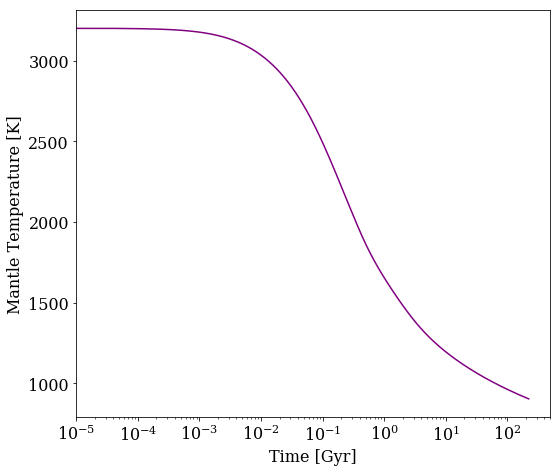

In [196]:
%matplotlib inline
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_SS*2.22, T_array_SS*1600., color='purple')
#plt.semilogx(tmp_time_array_SS*2.22, tmp_temp_array_SS*1600., color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
#plt.savefig('Recoded_SS_model_MantleTemp_noloss.pdf', bbox_inches='tight')
plt.savefig('Recoded_SS_model_MantleTemp_exploss.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


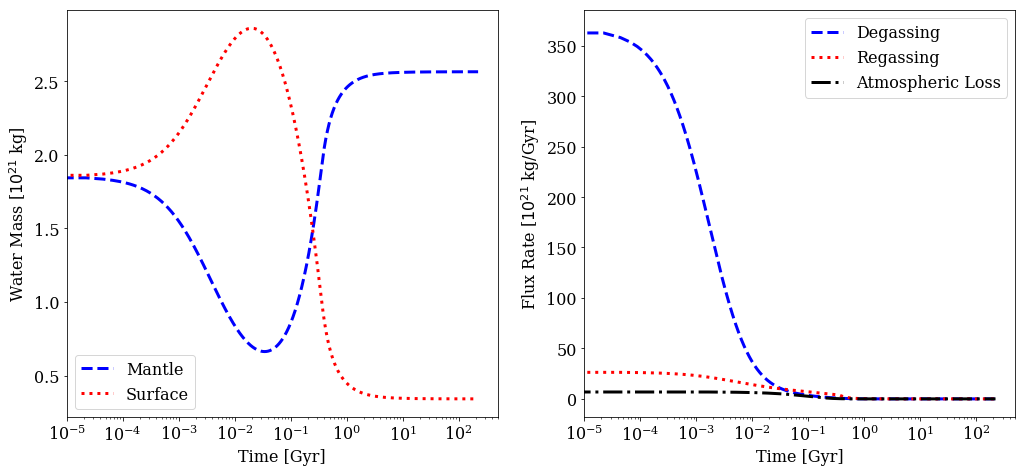

In [197]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_SS*2.22, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_SS*2.22, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_SS*2.22, (degas_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_SS*2.22, (regas_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_SS*2.22, (loss_array_SS*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
#plt.ylim([-1, 5.])
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_SS_model_cycling_noloss.pdf', bbox_inches='tight')
plt.savefig('Recoded_SS_model_cycling_exploss.pdf', bbox_inches='tight')

# Hybrid Model, using scipy.integrate --> GOOD!
## This is the quickest way to run through this cycling, so just code it this way from the beginning.

In [223]:
# Many functions have already been defined for the SS model -- only define new things here.
rho_m = 3.3e3
d_melt = 60.0e3
f_degasE = 0.9
omega_0 = 2.3e-4
f_btwid = 1.3
f_M = 0.68
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M

def Etwid(M):
    rho_m = 3.3e3
    d_melt = 60.0e3
    f_degasE = 0.9
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
    
    return E/D(M)

In [224]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.
def f_delta_temp_hyb(t_twid, temp_twid, x_twid, M):
    Q_0 = 5.0e-8
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    #tau_heat = Q_0/(rho_m*c_p*T_ref)
    
    #tau_decay = 2.0e9*3.154e7
    tau_decay_twid = 2.0e9*3.154e7/(rho_m*c_p*T_ref/F_0(M))
    F_0twid = F_0(M)/Q_0
    beta = 0.3
    T_stwid = 280./1600.
    
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a)
    #(tau_heat/tau(M))* on the first term?
    return ((1./F_0twid)*np.exp(-t_twid/tau_decay_twid)) - \
        ((f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M):
    chi_d = 0.02
    chi_r = 0.03
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    f_degasE = 0.9
    
    E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
    #D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Etwid_max = E/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        elif s_twid < 0:
             return 0. - (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid < 0:
             return 0. - 0.
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        return 0. - (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid#*((gtwid(M)**2.)*s_twid)**(-1.)
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M):
    chi_d = 0.02
    chi_r = 0.03
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    f_degasE = 0.9
    
    E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
    #D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Etwid_max = E/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_2twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # Terms for loss # XXXX ALL CONDITIONS HERE CAN BE CHANGED LATER XXXX
    omg_Etwid = 6.2e-4/2.3e-4
    f_btwid = 1.3
    omegatwid = omg_Etwid/(f_btwid)
    year = 3.154e7
    t_loss = 1.0e8 #e-folding timescale of 100 Myr
    #loss_factor = could use hybrid degassing rate here
    loss_factor = 10.*7.549547662687315
    #loss factor is 10 times the initial CA degassing rate (FOR NOW)
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.) - \
                (1./Etwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.) - \
                (1./Etwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
        elif s_twid < 0:
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid - 0. - 0.
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return 0. - (1./Etwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return 0. - (1./Etwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
        elif s_twid < 0:
            return 0. - 0. - 0.
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid - 0. - 0.
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_hyb(t_twid, z, M):
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    #Q_0 = 5.0e-8
    #F_0twid = F_0(M)/Q_0
    rho_m = 3.3e3
    c_p = 1200.
    T_ref = 1600.
    d_melt = 60.0e3
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    f_degasE = 0.9
    
    E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
    
    return [(F_0(M)/(rho_m*c_p*T_ref*tau(M)))*f_delta_temp_hyb(t_twid, temp_twid, x_twid, M),\
            (E/(Sigma(M)*tau(M)))*f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M),\
            (E/(Sigma(M)*tau(M)))*f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M)]
    

In [225]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_hyb(t_twid, temp_twid, x_twid, s_twid, M):
    chi_d = 0.02
    chi_r = 0.03
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    f_degasE = 0.9
    
    E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
    #D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Etwid_max = E/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.:
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M))*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max)*(f_wtwid(x_twid)**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0:
             return 0.
            
    elif s_twid <= 0.:
        return 0.
    
def f_degas_hyb(t_twid, temp_twid, x_twid, s_twid, M):
    chi_d = 0.02
    chi_r = 0.03
    theta = 1.5 #melt fraction exponent
    gamma = 0.75
    E_a = 335.0e3
    R_g = 8.314
    T_ref = 1600.
    T_liq_dry = 1225.+273.15
    T_sol_dry = 975.+273.15
    T_liqtwid = T_liq_dry/T_ref
    T_soltwid = T_sol_dry/T_ref
    T_serp = 973.
    T_s = 280.
    T_stwid = 280./1600. #surface temperature
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    x_h = 0.05
    rho_m = 3.3e3
    rho_c = 3.0e3
    beta = 0.3
    kappa = 1.0e-6
    Ra_c = 1100.
    r_fug = 1.
    eta_scale = (np.exp(lnf_w(1.)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    alpha = 2.0e-5
    d_melt = 60.0e3
    f_degasE = 0.9
    
    E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
    #D_2 = (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1.))))**beta
    
    Etwid_max = E/(D_2_max(temp_twid, x_twid, s_twid, M)*x_h*rho_c*chi_r)
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid)**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0.:
        
        if s_twid < 0.:
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid
        else:
            return (f_wtwid(x_twid)**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
    
    elif x_twid <= 0.:
        return 0.
    
def f_loss_hyb(t_twid, temp_twid, x_twid, s_twid, M):
    T_ref = 1600.
    T_stwid = 280./T_ref
    beta = 0.3
    R_g = 8.314
    E_a = 335.0e3
    T_mtwid = T_ref*R_g/(E_a) #another reference temperature
    gamma = 0.75
    theta = 1.5
    K_cnst = 43.
    Ktwid = K_cnst/T_ref
    omega_0 = 2.3e-4
    f_btwid = 1.3
    f_M = 0.68
    lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
    
    # Terms for loss # XXXX ALL CONDITIONS HERE CAN BE CHANGED LATER XXXX
    omg_Etwid = 6.2e-4/2.3e-4
    f_btwid = 1.3
    omegatwid = omg_Etwid/(f_btwid)
    year = 3.154e7
    t_loss = 1.0e8 #e-folding timescale of 100 Myr
    #loss_factor = could use hybrid degassing rate here
    loss_factor = 10.*7.549547662687315
    
    if s_twid > 0.: #normal loss
        return loss_factor*np.exp(-(t_twid/tau_SS(M)/year)/t_loss)
    elif s_twid <= 0.: #no loss
        return 0.

In [226]:
# Set initial conditions.
omegatwid = omg_Etwid/(f_btwid)
t0 = 0.
z0 = [2., omegatwid/2., omegatwid/2.]
M = M_E

# Set up function to be integrated.
r = ode(f_cycling_hyb).set_integrator('vode')
r.set_initial_value(z0, t0).set_f_params(M)

# Define max time, timestep, arrays to be filled within the integration loop.
t1 = 100.
dt = 1.e-5
t_array_hyb = np.zeros(int(t1/dt)+1)
T_array_hyb = np.zeros(int(t1/dt)+1)
x_array_hyb = np.zeros(int(t1/dt)+1)
s_array_hyb = np.zeros(int(t1/dt)+1)
regas_array_hyb = np.zeros(int(t1/dt)+1)
degas_array_hyb = np.zeros(int(t1/dt)+1)
#d_hydr_CA = np.zeros(int(t1/dt))
#eta_array_CA = np.zeros(int(t1/dt))

# Initial values in the arrays.
t_array_hyb[0] = t0
T_array_hyb[0] = z0[0]
x_array_hyb[0] = z0[1]
s_array_hyb[0] = z0[2]
regas_array_hyb[0] = f_regas_hyb(t0, z0[0], z0[1], z0[2], M)
degas_array_hyb[0] = f_degas_hyb(t0, z0[0], z0[1], z0[2], M)

# Integrate the above function.
idx = 1
while r.successful() and r.t < t1:
    r.integrate(r.t+dt)
    t_array_hyb[idx] = r.t
    T_array_hyb[idx] = r.y[0]
    x_array_hyb[idx] = r.y[1]
    s_array_hyb[idx] = r.y[2]
    regas_array_hyb[idx] = f_regas_hyb(r.t, r.y[0], r.y[1], r.y[2], M)
    degas_array_hyb[idx] = f_degas_hyb(r.t, r.y[0], r.y[1], r.y[2], M)
    idx = idx + 1

<Figure size 1224x540 with 0 Axes>

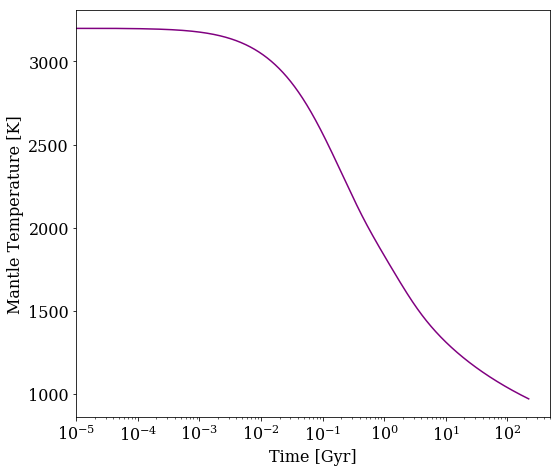

In [227]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
fig = plt.figure(figsize=(8.5,7.5))
plt.semilogx(t_array_hyb*2.22, T_array_hyb*1600., color='purple')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
#plt.savefig('Recoded_hyb_model_MantleTemp_noloss.pdf', bbox_inches='tight')
plt.savefig('Recoded_hyb_model_MantleTemp_exploss.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


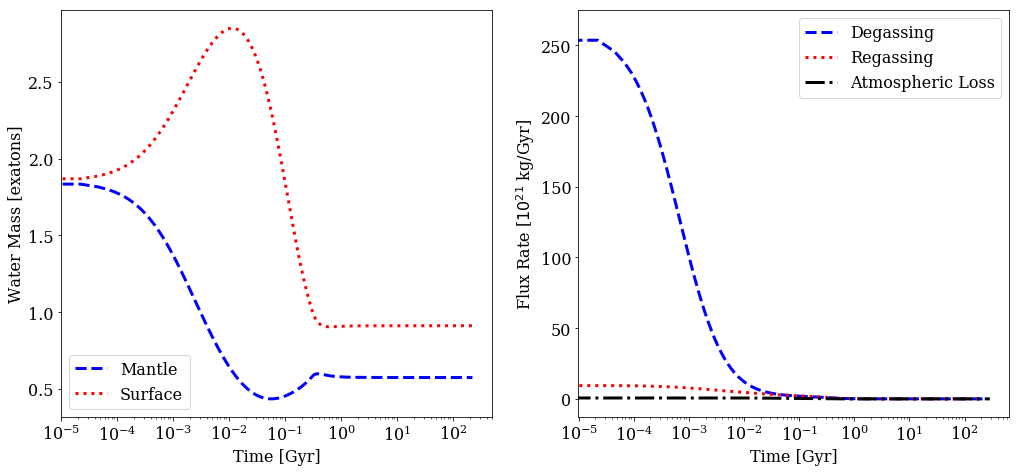

In [228]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_hyb*2.22, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Mantle')
plt.semilogx(t_array_hyb*2.22, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Surface')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [exatons]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

dr_conv = (3*np.pi*(6.3781e6)*(0.1/31536000.)*0.05*3.0e3*0.23*3.0e3/0.68) #[kg/s]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_hyb*2.22, (degas_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb*2.22, (regas_array_hyb*dr_conv*exa_gyr_conv), linewidth=3, color='r', linestyle=':', label='Regassing')
plt.semilogx(t_array_CA*2.87, (loss_array_CA*dr_conv*exa_gyr_conv), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_hyb_model_cycling_noloss.pdf', bbox_inches='tight')
plt.savefig('Recoded_hyb_model_cycling_exploss.pdf', bbox_inches='tight')